In [1]:
import paddle
import numpy as np
import sys
sys.path.append('../')
from utils import *
from kan_efficiency import *
from kan_rbf import *
import time
import pandas as pd
from tqdm import tqdm
import random
from statistics import mean, median
import matplotlib.pyplot as plt
import GPUtil
import csv
from scipy.io import loadmat
from layers.KAN_layers import *

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script


In [2]:
# 根据资源情况选择使用的设备

available_gpus = GPUtil.getAvailable(order='memory', limit=1, maxLoad=0.5, maxMemory=0.5)
if len(available_gpus) == 0:
    print("No GPU available, using CPU")
    paddle.set_device('cpu')
else:
    selected_gpu = available_gpus[0]
    print(f"Using GPU {selected_gpu}")
    paddle.set_device(f'gpu:{selected_gpu}')

Using GPU 0


In [3]:
def get_data(filename, ndata):
    r =15
    s = int(((421-1) / 15) + 1)

    data = loadmat(filename)
    x_branch = data["coeff"][:ndata, ::r, ::r].astype(np.float32) * 0.1 - 0.75
    y = data["sol"][:ndata, ::r, ::r].astype(np.float32) * 100

    y[:, 0, :] = 0
    y[:, -1, :] = 0
    y[:, :, 0] = 0
    y[:, :, -1] = 0

    grids = []
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

    x_branch = x_branch.reshape(ndata, s * s)

    y = y.reshape(ndata, s * s)
    return x_branch, grid, y


In [4]:
c, x, y = get_data("piececonst_r421_N1024_smooth1.mat", 1000)
c_train = c[0:800]
y_train = y[0:800]
c_test = c[800:]
y_test = y[800:]
print(c_train.shape)
print(y_train.shape)

(800, 841)
(800, 841)


In [5]:
x = paddle.to_tensor(x, dtype='float32')
c_train = paddle.to_tensor(c_train, dtype='float32')
c_test = paddle.to_tensor(c_test, dtype='float32')
y_train = paddle.to_tensor(y_train, dtype='float32')
y_test = paddle.to_tensor(y_test, dtype='float32')

In [6]:
input_dim_trunk = x.shape[1]
input_dim_branch = c_train.shape[1]
HD = 40
hid_trunk = 64
num_layer_trunk = 1
hid_branch = 64
num_layer_branch = 1
dtype = paddle.float32
# KAN parameters
grid_opt = True # Grid points trainable or not
apply_base_update = False # apply base update or not
grid_count = 20 # number of grid points
init_scale = 0.01
noise_scale = 0.01
learning_rate = 1e-3
batch_size = 32
epochs = 2000
gamma = 0.95
step_size = 500 # step size for learning rate decay
random_seed = 2323
branch_kan_func = 'bspline'
trunk_kan_func = 'bspline'

trunk_min_grid = x.min()
trunk_max_grid = x.max()
branch_min_grid = c_train.min()
branch_max_grid = c_train.max()
width_trunk = kan_width(input_dim_trunk, hid_trunk, num_layer_trunk, HD)
width_branch = kan_width(input_dim_branch, hid_branch, num_layer_branch, HD)

print(f'Trunk net hidden neurons: {width_trunk}, num layers: {num_layer_trunk}, width: {width_trunk}')
print(f'Branch net hidden neurons: {width_branch}, num layers: {num_layer_branch}, width: {width_branch}')

c_train = paddle.to_tensor(c_train, dtype=dtype)
c_test = paddle.to_tensor(c_test, dtype=dtype)
y_train = paddle.to_tensor(y_train, dtype=dtype)
y_test = paddle.to_tensor(y_test, dtype=dtype)
out_0 = c_train.clone().detach()
out_0.stop_gradient = False
c_train = out_0.to(dtype)
out_1 = y_train.clone().detach()
out_1.stop_gradient = not True
y_train = out_1.to(dtype)
out_2 = y_test.clone().detach()
out_2.stop_gradient = not True
y_test = out_2.to(dtype)
out_3 = y_test.clone().detach()
out_3.stop_gradient = not True
y_test = out_3.to(dtype)

Trunk net hidden neurons: [2, 64, 40], num layers: 1, width: [2, 64, 40]
Branch net hidden neurons: [841, 64, 40], num layers: 1, width: [841, 64, 40]


W0314 07:05:33.984006 37458 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0314 07:05:33.985275 37458 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.
/tmp/ipykernel_37458/496086793.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach(), rather than paddle.to_tensor(sourceTensor).
  c_train = paddle.to_tensor(c_train, dtype=dtype)


In [7]:
model_rbf = KANONet(width_branch=width_branch, width_trunk=width_trunk, 
                 trunk_min_grid=trunk_min_grid, trunk_max_grid=trunk_max_grid,
                 branch_min_grid=branch_min_grid, branch_max_grid=branch_max_grid,
                 grid_count=grid_count, grid_opt=grid_opt,
                 apply_base_update=apply_base_update, noise_scale=noise_scale, dtype=dtype,
                 branch_kan_func=branch_kan_func, trunk_kan_func=trunk_kan_func)
criterion = RMSLoss()
optimizer = paddle.optimizer.Adam(learning_rate=learning_rate, parameters=model_rbf.parameters(), weight_decay=0.0)
tmp_lr = paddle.optimizer.lr.StepDecay(step_size=step_size, gamma=gamma, learning_rate=optimizer.get_lr())
optimizer.set_lr_scheduler(tmp_lr)
scheduler = tmp_lr

W0314 07:05:33.997725 37458 multiply_fwd_func.cc:76] got different data type, run type promotion automatically, this may cause data type been changed.


In [8]:

set_seed(random_seed)
num_learnable_parameters = count_learnable_parameters(model_rbf)
print(num_learnable_parameters)
for name, param in model_rbf.named_parameters():
    if not param.stop_gradient:
        print(f"Parameter Name: {name}")
        print(f"Shape: {param.shape}")
        print(f"Number of Parameters: {param.numel()}")

1476800
Parameter Name: trunk_net.layers.0.base_weight
Shape: [64, 2]
Number of Parameters: 128
Parameter Name: trunk_net.layers.0.spline_weight
Shape: [64, 2, 23]
Number of Parameters: 2944
Parameter Name: trunk_net.layers.0.spline_scaler
Shape: [64, 2]
Number of Parameters: 128
Parameter Name: trunk_net.layers.1.base_weight
Shape: [40, 64]
Number of Parameters: 2560
Parameter Name: trunk_net.layers.1.spline_weight
Shape: [40, 64, 23]
Number of Parameters: 58880
Parameter Name: trunk_net.layers.1.spline_scaler
Shape: [40, 64]
Number of Parameters: 2560
Parameter Name: branch_net.layers.0.base_weight
Shape: [64, 841]
Number of Parameters: 53824
Parameter Name: branch_net.layers.0.spline_weight
Shape: [64, 841, 23]
Number of Parameters: 1237952
Parameter Name: branch_net.layers.0.spline_scaler
Shape: [64, 841]
Number of Parameters: 53824
Parameter Name: branch_net.layers.1.base_weight
Shape: [40, 64]
Number of Parameters: 2560
Parameter Name: branch_net.layers.1.spline_weight
Shape: [40

In [ ]:
train_losses = []
test_losses = []
start_time = time.time()
mean_test_loss = 0.0
results = []

for epoch in range(epochs):
    model_rbf.train()
    total_loss  =0
    indices = range(0, len(c_train), batch_size)
    
    progress_bar = tqdm(range(0, len(c_train), batch_size), desc=f'Epoch{epoch + 1}/{epochs}')
    
    for i in progress_bar:
        c_batch = c_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        optimizer.clear_grad()
        y_pred = model_rbf(c_batch, x)
        loss = criterion(y_pred, y_batch)
        loss.backward(retain_graph=True)
        optimizer.step()

        total_loss += loss.item()
        
        progress_bar.set_postfix({'Batch loss': loss.item()})
    avg_loss = total_loss / (len(c_train) // batch_size + 1)
    train_losses.append(avg_loss)
    test_loss = test_model(model=model_rbf, criterion=criterion, c_test=c_test, y_test=y_test, x=x, batch_size=batch_size)
    test_losses.append(test_loss)
    results.append([epoch+1, avg_loss, test_loss])
    if epoch % 500 == 0:
        print(f'After Epoch {epoch}, Average Train Loss: {avg_loss}, Test Loss: {test_loss}')
    scheduler.step()
end_time = time.time()
training_time = end_time - start_time

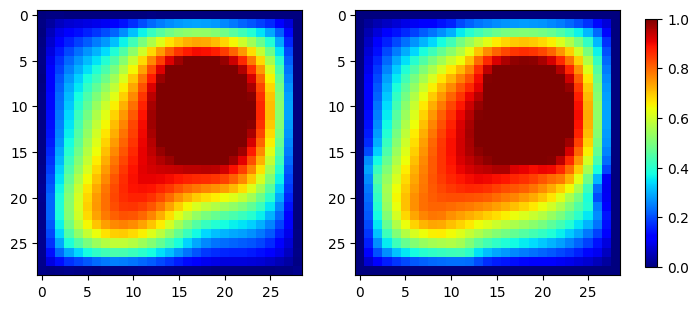

In [17]:
idx = np.random.choice(c_test.shape[0], 1, replace=False)

model_rbf.eval()
with paddle.no_grad():
    y_pred = model_rbf(c_test[idx], x)
    y_pred = y_pred.reshape(shape=[29, 29]).numpy()
    y_true = y_test[idx].reshape(shape=[29, 29]).numpy()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Display the images
    im1 = axs[0].imshow(y_pred, cmap='jet', vmin=0, vmax=1)
    im2 = axs[1].imshow(y_true, cmap='jet', vmin=0, vmax=1)

    # Add a single color bar for both subplots
    cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

    plt.show()

In [11]:
paddle.save(model_rbf.state_dict(), 'darcy.pdparams')

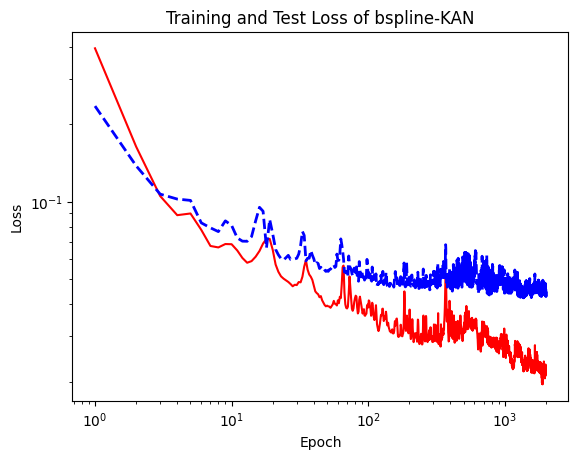

In [15]:
plt.figure()
results = np.asarray(results)
plt.plot(results[:,0], results[:,1], 'r', label='Training Loss')
plt.plot(results[:,0], results[:,2], 'b--', lw = 2,label='Test Loss')
plt.xscale('log')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.title('Training and Test Loss of '+ branch_kan_func+'-KAN')
plt.show()

In [12]:
model_rbf = KANONet(width_branch=width_branch, width_trunk=width_trunk, 
                 trunk_min_grid=trunk_min_grid, trunk_max_grid=trunk_max_grid,
                 branch_min_grid=branch_min_grid, branch_max_grid=branch_max_grid,
                 grid_count=grid_count, grid_opt=grid_opt,
                 apply_base_update=apply_base_update, noise_scale=noise_scale, dtype=dtype,
                 branch_kan_func=branch_kan_func, trunk_kan_func=trunk_kan_func)
params = paddle.load('darcy.pdparams')
model_rbf.set_state_dict(params)
model_rbf.eval()

In [18]:
s = 50
grids = []
grids.append(np.linspace(0, 1, s, dtype=np.float32))
grids.append(np.linspace(0, 1, s, dtype=np.float32))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = paddle.to_tensor(grid, dtype='float32')
print(grid.shape)
y_pred = model_rbf(c_test[idx], grid)

[2500, 2]


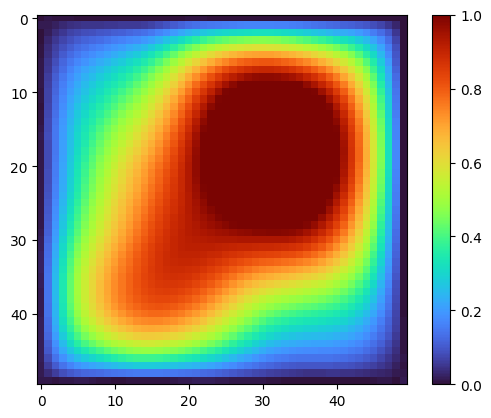

In [19]:
plt.figure()
plt.imshow(y_pred.reshape([s,s]).numpy(), cmap='turbo', vmin=0, vmax=1)
plt.colorbar()
plt.show()